In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline,
)


# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

img_height = 512
img_width = 512

init_image = download_image(img_url).resize((img_height, img_width))
mask_image = download_image(mask_url).resize((img_height, img_width))

In [2]:
# Set device
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

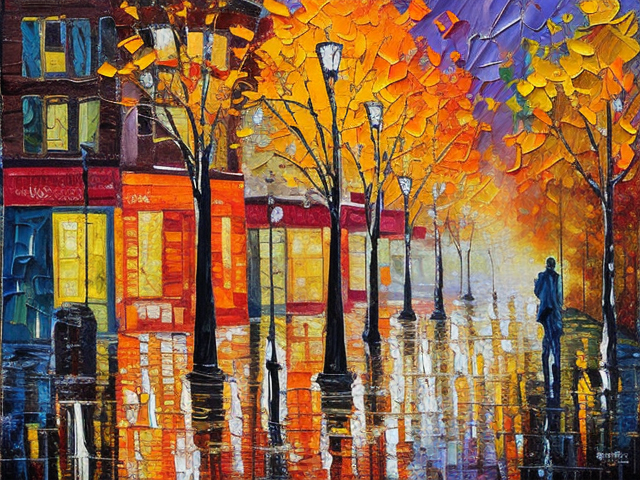

In [4]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape",  # What to generate
    negative_prompt="Oversaturated, blurry, low quality",  # What NOT to generate
    height=480,
    width=640,  # Specify the image size
    guidance_scale=8,  # How strongly to follow the prompt
    num_inference_steps=35,  # How many steps to take
    generator=generator,  # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

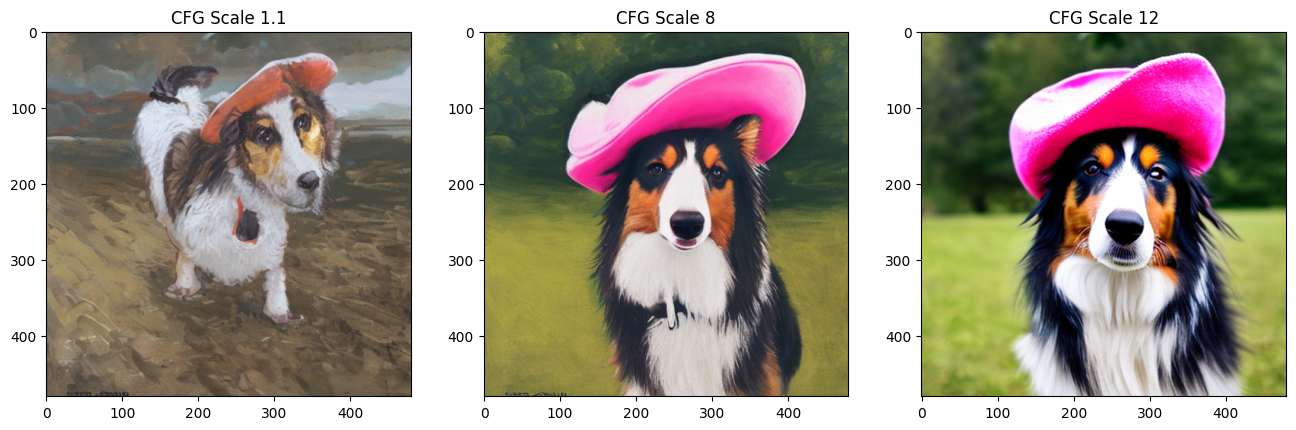

In [5]:
# @markdown comparing guidance scales:
cfg_scales = [1.1, 8, 12]  # @param
prompt = "A collie with a pink hat"  # @param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(
        prompt,
        height=480,
        width=480,
        guidance_scale=cfg_scales[i],
        num_inference_steps=35,
        generator=torch.Generator(device=device).manual_seed(42),
    ).images[0]
    ax.imshow(im)
    ax.set_title(f"CFG Scale {cfg_scales[i]}")

In [6]:
print(list(pipe.components.keys()))  # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


In [7]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


In [8]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])["input_ids"]
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)["last_hidden_state"]
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [11]:
# Get the final text embeddings using the pipeline's encode_prompt function
text_embeddings = pipe.encode_prompt("A painting of a flooble", device, 1, True, "")
text_embeddings

(tensor([[[-0.3134, -0.4476, -0.0082,  ...,  0.2542, -0.0324, -0.2960],
          [ 0.1996, -1.6936, -0.8946,  ...,  0.4658, -0.0956, -2.1484],
          [ 0.4134, -1.1114, -0.4718,  ...,  1.8329,  0.6236, -0.4375],
          ...,
          [ 0.5295, -1.6469, -0.0614,  ..., -0.2134, -0.0888,  0.0104],
          [ 0.5855, -1.6530, -0.1027,  ..., -0.4814, -0.1509,  0.1602],
          [ 0.3503, -2.4010, -0.8219,  ..., -0.2327, -0.0964,  0.8592]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[[-3.1343e-01, -4.4757e-01, -8.2412e-03,  ...,  2.5421e-01,
           -3.2432e-02, -2.9603e-01],
          [ 1.4114e+00,  7.5782e-03, -4.2884e-01,  ...,  1.0365e+00,
           -6.7341e-01,  1.5006e+00],
          [ 1.8676e+00, -1.0888e+00, -1.0656e+00,  ...,  2.0319e+00,
           -1.1396e+00, -1.8952e-01],
          ...,
          [ 6.0658e-03, -1.4990e+00, -3.9075e-01,  ..., -1.7927e-01,
           -3.2250e-01, -1.5238e-02],
          [ 2.7662e-02, -1.5532e+00, -4.1506e-01,  ..., -

In [12]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print("UNet output shape:", unet_output.shape)  # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


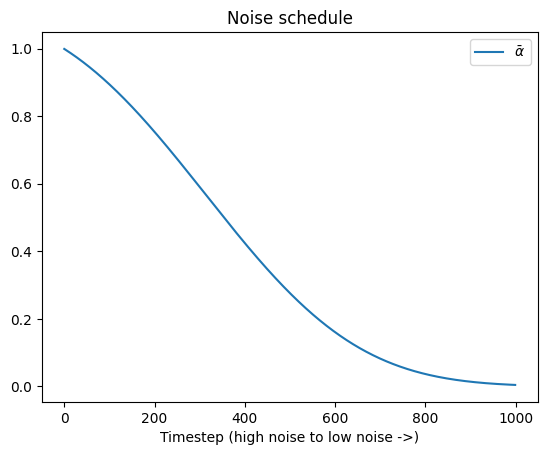

In [13]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r"$\bar{\alpha}$")
plt.xlabel("Timestep (high noise to low noise ->)")
plt.title("Noise schedule")
plt.legend()

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.34.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}



  0%|          | 0/50 [00:00<?, ?it/s]

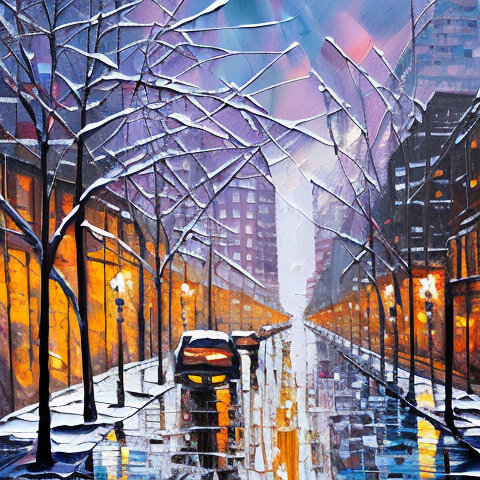

In [5]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print("Scheduler config:", pipe.scheduler)

# Generate an image with this new scheduler
pipe(
    prompt="Palette knife painting of an winter cityscape",
    height=480,
    width=480,
    generator=torch.Generator(device=device).manual_seed(42),
).images[0]

/home/dakoro/Github/ai-experiments/.venv/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
/home/dakoro/Github/ai-experiments/.venv/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:599: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


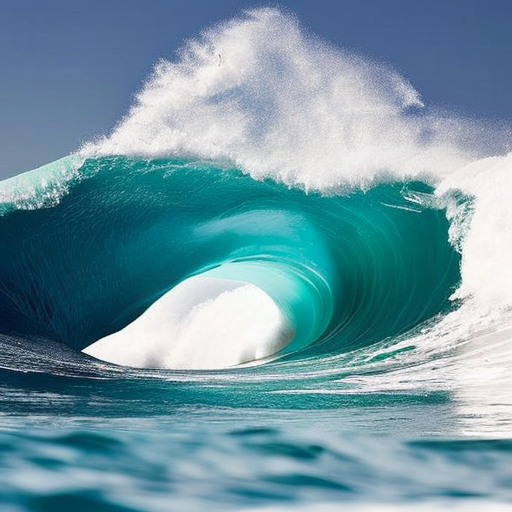

In [ ]:
guidance_scale = 8  # @param
num_inference_steps = 30  # @param
prompt = "Beautiful picture of a wave breaking"  # @param
negative_prompt = "zoomed in, blurry, oversaturated, warped"  # @param

# Encode the prompt
text_embeddings = pipe.encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

In [7]:
import numpy as np

# Encode init_image
init_image_tensor = torch.from_numpy(np.array(init_image).transpose(2, 0, 1)).float() / 255.0  # 0~255 => 0~1
init_image_tensor = 2.0 * init_image_tensor - 1.0  # 0~1 => -1~1
init_image_tensor = init_image_tensor.unsqueeze(0).to(device)  # add batch dim.

with torch.no_grad():
    init_image_latents = pipe.vae.encode(init_image_tensor).latent_dist.sample() * pipe.vae.config.scaling_factor

Text(0.5, 1.0, 'Result')

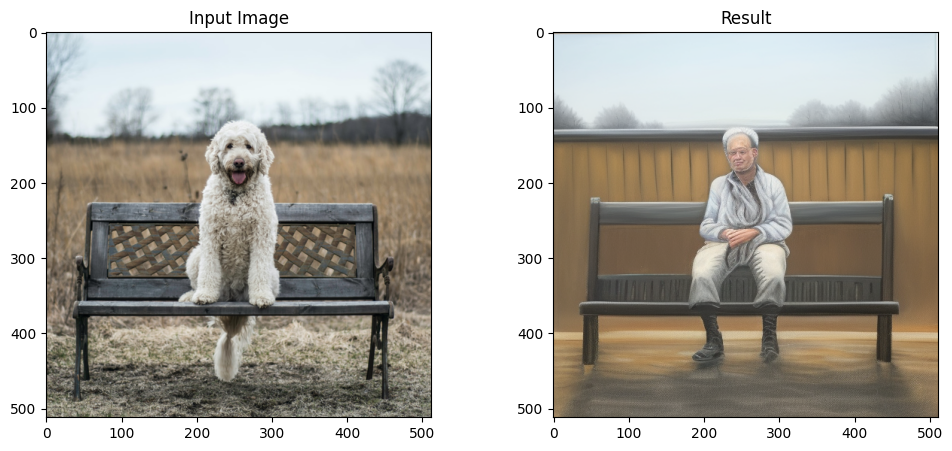

In [8]:
guidance_scale = 7.5  # @param
num_inference_steps = 30  # @param
strength = 0.6
prompt = "An oil painting of a man on a bench"  # @param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, "")

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Prepare latent variables
# We don't use all timesteps in the noise scheduler.
# Calculate a subset of timesteps based on `strength` to apply to the initial image.
init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = pipe.scheduler.timesteps[t_start:]
# The first timestep of the new timesteps will be the starting point for adding noise to the initial image.
latent_timestep = timesteps[:1]

# Add noise to init_image_latents at the noise level specified by latent_timestep.
noise = torch.randn((1, 4, 64, 64), device=device, generator=torch.Generator(device=device).manual_seed(42))
latents = pipe.scheduler.add_noise(init_image_latents, noise, latent_timestep)

# Loop through the sampling timesteps
for i, t in enumerate(timesteps):

    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode latents
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    result_image = pipe.vae.decode(latents_norm).sample

result_image = (result_image / 2 + 0.5).clamp(0, 1).squeeze()
result_image = (result_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
result_image = Image.fromarray(result_image)

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(result_image)
axs[1].set_title("Result")

In [4]:
# Loading an Img2Img pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 7.61 GiB of which 47.81 MiB is free. Including non-PyTorch memory, this process has 6.41 GiB memory in use. Of the allocated memory 6.25 GiB is allocated by PyTorch, and 37.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Result')

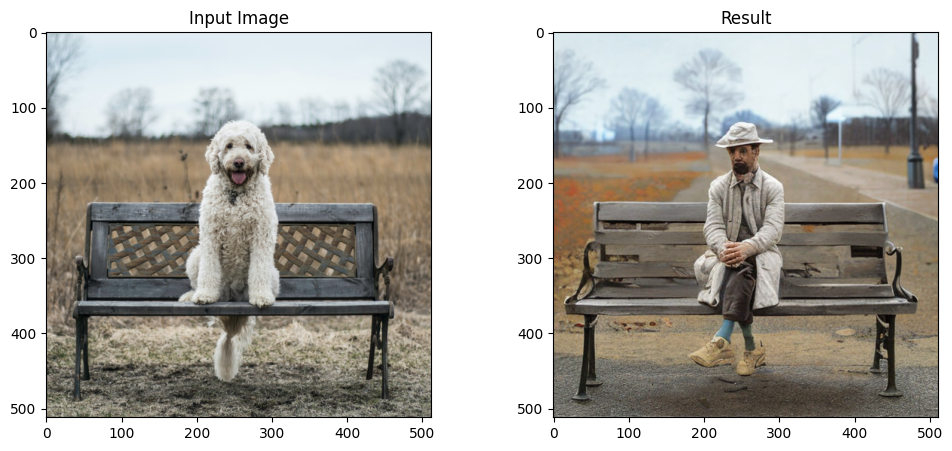

In [4]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image=init_image,  # The starting image
    strength=0.6,  # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(result_image)
axs[1].set_title("Result")

torch.Size([64, 64])

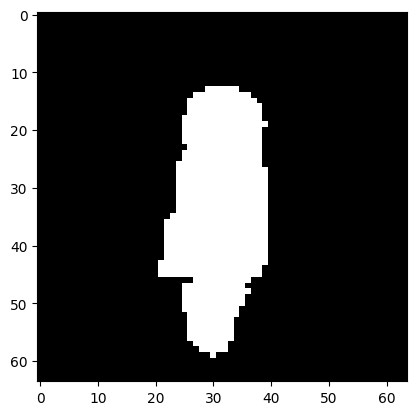

In [6]:
# Resize mask image
import numpy as np
mask_image_latent_size = mask_image.resize((64, 64))
mask_image_latent_size = torch.tensor((np.array(mask_image_latent_size)[..., 0] > 5).astype(np.float32))
plt.imshow(mask_image_latent_size.numpy(), cmap="gray")

mask_image_latent_size = mask_image_latent_size.to(device)
mask_image_latent_size.shape

In [ ]:
guidance_scale = 8  # @param
num_inference_steps = 30  # @param
prompt = "A small robot, high resolution, sitting on a park bench"
negative_prompt = "zoomed in, blurry, oversaturated, warped"
generator = torch.Generator(device=device).manual_seed(42)

# Encode the prompt
text_embeddings = pipe.encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

for i, t in enumerate(pipe.scheduler.timesteps):
    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    # Perform inpainting to fill in the masked areas
    if i < len(pipe.scheduler.timesteps) - 1:
        # Add noise to the original image's latent at the previous timestep t-1
        noise = torch.randn(init_image_latents.shape, generator=generator, device=device, dtype=torch.float32)
        background = pipe.scheduler.add_noise(
            init_image_latents, noise, torch.tensor([pipe.scheduler.timesteps[i + 1]])
        )

        latents = latents * mask_image_latent_size  # white in the areas
        background = background * (1 - mask_image_latent_size)  # black in the areas

        # Combine the generated and original image latents based on the mask
        latents += background

# Decode latents
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    inpainted_image = pipe.vae.decode(latents_norm).sample

inpainted_image = (inpainted_image / 2 + 0.5).clamp(0, 1).squeeze()
inpainted_image = (inpainted_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
inpainted_image = Image.fromarray(inpainted_image)

inpainted_image

NameError: name 'pipe' is not defined

In [1]:
# Load the inpainting pipeline (requires a suitable inpainting model)
# pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")

# "runwayml/stable-diffusion-inpainting" is no longer available.
# Therefore, we are using the "stabilityai/stable-diffusion-2-inpainting" model instead.
pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting")
pipe = pipe.to(device)

NameError: name 'StableDiffusionInpaintPipeline' is not defined

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(mask_image)
axs[1].set_title("Mask")
axs[2].imshow(image)
axs[2].set_title("Result")

In [2]:
!ls ~/.cache/huggingface/hub/ # List the contents of the cache directory

datasets--derekl35--alphonse-mucha-style
models--answerdotai--ModernBERT-base
models--BAAI--bge-large-en-v1.5
models--bert-base-uncased
models--black-forest-labs--FLUX.1-dev
models--cardiffnlp--twitter-roberta-base-emotion-multilabel-latest
models--gpt2
models--hubertsiuzdak--snac_24khz
models--naver--splade-cocondenser-ensembledistil
models--nvidia--Llama3-ChatQA-1.5-8B
models--openai--clip-vit-base-patch32
models--Qwen--Qwen3-Embedding-0.6B
models--stabilityai--stable-diffusion-2-1-base
version.txt
